In [1]:
import re
import pandas as pd

In [2]:
top5_2023_2024 = pd.read_csv("./Data/Raw Data/top5leagues_ratings_2023-2024.csv")
top5_2022_2023 = pd.read_csv("./Data/Raw Data/top5leagues_ratings_2022-2023.csv")
top5_2021_2022 = pd.read_csv("./Data/Raw Data/top5leagues_ratings_2021-2022.csv")

In [3]:
def extract_name(text):
    # Remove leading digits and spaces
    text = re.sub(r'^\d+\s*', '', text)

    first_part = text.split(',')[0]
    
    # Split the text into words while keeping hyphenated names together, including accented characters
    words = re.findall(r'\b[A-Za-zÀ-ÖØ-öø-ÿ]+(?:-[A-Za-zÀ-ÖØ-öø-ÿ]+)?\b', first_part)
    # print(words)

    player_name = []
    team_name = []

    team_started = False

    for word in words:
        uppercase_count = sum(1 for c in word if c.isupper())

        # If the word contains more than one uppercase letter and is not hyphenated, split it into player and team names
        if uppercase_count > 1 and '-' not in word and not team_started:
            # Split the word: the first part goes to the player's last name and the second part is the team name
            match = re.search(r'([a-zà-öø-ÿA-Z]+)([A-Z].*)', word)
            if match:
                player_name.append(match.group(1))  # Append the first part (last name of the player)
                team_name.append(match.group(2))    # Append the team name part
            team_started = True
        elif team_started:
            # Once team name starts, continue appending words to the team name
            team_name.append(word)
        else:
            # Add words to player name until team name starts
            player_name.append(word)

    # Check if team name is still empty and if the last part is part of the team name
    if not team_name:
        last_word = player_name[-1]
        team_match = re.search(r'(.*)(Tottenham|Man Utd|City|Chelsea|Palace|Arsenal|Liverpool|Brighton)', last_word, re.IGNORECASE)
        if team_match:
            player_name[-1] = team_match.group(1)  # Correct the player name if it's concatenated with the team
            team_name.append(team_match.group(2))  # Add the correct team name

    player = ' '.join(player_name)
    team = ' '.join(team_name)

    return player, team

In [4]:
top5_2023_2024[['Player Name', 'Squad']] = top5_2023_2024['Player Name'].apply(
    lambda x: pd.Series(extract_name(x))
)
top5_2023_2024.to_csv("cleaned_top_5_2023_2024.csv")
top5_2022_2023[['Player Name', 'Squad']] = top5_2022_2023['Player Name'].apply(
    lambda x: pd.Series(extract_name(x))
)
top5_2022_2023.to_csv("cleaned_top_5_2022_2023.csv")
top5_2021_2022[['Player Name', 'Squad']] = top5_2021_2022['Player Name'].apply(
    lambda x: pd.Series(extract_name(x))
)
top5_2021_2022.to_csv("cleaned_top_5_2021_2022.csv")

In [5]:
# !pip install rapidfuzz
from rapidfuzz import process
def get_fuzzy_rating(player, squad, df_players):
    # Get fuzzy match for player names
    best_player_match = process.extractOne(player, df_players["Player Name"].tolist(), score_cutoff=50)
    
    # Get fuzzy match for squad (club) names
    best_squad_match = process.extractOne(squad, df_players["Squad"].tolist(), score_cutoff=30)

    if best_player_match and best_squad_match:
        matched_name = best_player_match[0]
        matched_squad = best_squad_match[0]
        
        # Find the rating using both player and squad match
        matched_rating = df_players[
            (df_players["Player Name"] == matched_name) & 
            (df_players["Squad"] == matched_squad)
        ]["Rating"].values

        if matched_rating.size > 0:
            return matched_rating[0]
    return None  # Return None if no match found

In [6]:
def clean_league_name(league):
    return re.sub(r'^\S+\s+', '', league)  # Removes the first word and space

In [7]:
filtered_df = pd.read_csv("./Data/all_players_polished.csv")

In [8]:
df_2023_2024 = filtered_df[filtered_df["Season"] == "2023-2024"].copy()
df_2023_2024['League'] = df_2023_2024['League'].apply(clean_league_name)

# Merge ratings on 'Player Name' (keeping all existing players)
df_2023_2024 = pd.merge(
    df_2023_2024,
    top5_2023_2024[['Player Name', 'Squad', 'Rating']], 
    on=['Player Name', 'Squad'], 
    how='left'
)

# Apply fuzzy matching for players missing ratings
df_2023_2024["Rating"] = df_2023_2024.apply(
    lambda row: get_fuzzy_rating(row["Player Name"], row["Squad"], top5_2023_2024) 
    if pd.isnull(row["Rating"]) else row["Rating"],
    axis=1
)

In [9]:
df_2022_2023 = filtered_df[filtered_df["Season"] == "2022-2023"].copy()
df_2022_2023['League'] = df_2022_2023['League'].apply(clean_league_name)

# Merge ratings on 'Player Name' (keeping all existing players)
df_2022_2023 = pd.merge(
    df_2022_2023,
    top5_2022_2023[['Player Name', 'Squad', 'Rating']], 
    on=['Player Name', 'Squad'], 
    how='left'
)

# Apply fuzzy matching for players missing ratings
df_2022_2023["Rating"] = df_2022_2023.apply(
    lambda row: get_fuzzy_rating(row["Player Name"], row["Squad"], top5_2022_2023) 
    if pd.isnull(row["Rating"]) else row["Rating"],
    axis=1
)

In [10]:
df_2021_2022 = filtered_df[filtered_df["Season"] == "2021-2022"].copy()
df_2021_2022['League'] = df_2021_2022['League'].apply(clean_league_name)

# Merge the ratings on 'Player Name' (keeping all existing players)
df_2021_2022 = pd.merge(
    df_2021_2022,
    top5_2021_2022[['Player Name', 'Squad', 'Rating']], 
    on=['Player Name', 'Squad'], 
    how='left'
)

# Apply fuzzy matching for players missing ratings
df_2021_2022["Rating"] = df_2021_2022.apply(
    lambda row: get_fuzzy_rating(row["Player Name"], row["Squad"], top5_2021_2022) 
    if pd.isnull(row["Rating"]) else row["Rating"],
    axis=1
)

In [11]:
df_2023_2024 = df_2023_2024.drop_duplicates()
df_2022_2023 = df_2022_2023.drop_duplicates()
df_2021_2022 = df_2021_2022.drop_duplicates()

In [12]:
finalized_df = pd.concat([df_2023_2024, df_2022_2023, df_2021_2022], ignore_index=False)

In [13]:
finalized_df

,Player Name,Pos,Squad,League,90s,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,...,Off,Crs,PKcon,OG,Recov,Won,Lost,Won%,Season,Rating
0,Max Aarons,DF,Bournemouth,Premier League,13.7,29,19,20,7,2,...,2,13,1,0,75,5,11,31.3,2023-2024,6.25
1,Brenden Aaronson,"MF,FW",Union Berlin,Bundesliga,14.1,32,18,13,13,6,...,5,22,0,0,88,13,16,44.8,2023-2024,6.40
2,Yunis Abdelhamid,DF,Reims,Ligue 1,30.9,64,35,36,23,5,...,0,3,0,1,149,61,37,62.2,2023-2024,6.77
3,Salis Abdul Samed,MF,Lens,Ligue 1,16.9,21,14,8,10,3,...,0,3,3,0,89,2,7,22.2,2023-2024,6.22
4,Laurent Abergel,MF,Lorient,Ligue 1,31.8,85,52,43,34,8,...,1,34,0,0,226,15,14,51.7,2023-2024,6.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019,Martín Zubimendi,MF,Real Sociedad,La Liga,28.8,52,25,19,30,3,...,3,2,0,0,139,63,24,72.4,2021-2022,6.76
2020,Szymon Żurkowski,MF,Empoli,Serie A,25.6,58,33,24,21,13,...,0,23,1,0,162,24,32,42.9,2021-2022,6.80
2021,Martin Ødegaard,"MF,FW",Arsenal,Premier League,30.9,49,21,6,24,19,...,3,59,2,0,162,14,23,37.8,2021-2022,6.91
2022,Milan Đurić,FW,Salernitana,Serie A,24.1,1,1,0,1,0,...,6,2,0,0,40,242,83,74.5,2021-2022,NaN


In [14]:
nan_indices = finalized_df[finalized_df.isna().any(axis=1)].index
print(nan_indices)

Index([  26,   28,   53,   63,   68,   76,   82,   87,   88,  112,
       ...
       1838, 1874, 1883, 1884, 1903, 1916, 1947, 1948, 1950, 2022],
      dtype='int64', length=371)


In [15]:
nan_count = finalized_df.isna().any(axis=1).sum()
print(nan_count)

371


In [16]:
clean_df = finalized_df.dropna()

In [17]:
clean_df

,Player Name,Pos,Squad,League,90s,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,...,Off,Crs,PKcon,OG,Recov,Won,Lost,Won%,Season,Rating
0,Max Aarons,DF,Bournemouth,Premier League,13.7,29,19,20,7,2,...,2,13,1,0,75,5,11,31.3,2023-2024,6.25
1,Brenden Aaronson,"MF,FW",Union Berlin,Bundesliga,14.1,32,18,13,13,6,...,5,22,0,0,88,13,16,44.8,2023-2024,6.40
2,Yunis Abdelhamid,DF,Reims,Ligue 1,30.9,64,35,36,23,5,...,0,3,0,1,149,61,37,62.2,2023-2024,6.77
3,Salis Abdul Samed,MF,Lens,Ligue 1,16.9,21,14,8,10,3,...,0,3,3,0,89,2,7,22.2,2023-2024,6.22
4,Laurent Abergel,MF,Lorient,Ligue 1,31.8,85,52,43,34,8,...,1,34,0,0,226,15,14,51.7,2023-2024,6.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,Igor Zubeldia,DF,Real Sociedad,La Liga,18.3,20,10,12,8,0,...,1,4,1,0,90,41,34,54.7,2021-2022,6.41
2019,Martín Zubimendi,MF,Real Sociedad,La Liga,28.8,52,25,19,30,3,...,3,2,0,0,139,63,24,72.4,2021-2022,6.76
2020,Szymon Żurkowski,MF,Empoli,Serie A,25.6,58,33,24,21,13,...,0,23,1,0,162,24,32,42.9,2021-2022,6.80
2021,Martin Ødegaard,"MF,FW",Arsenal,Premier League,30.9,49,21,6,24,19,...,3,59,2,0,162,14,23,37.8,2021-2022,6.91


In [18]:
clean_df["Pos"].unique()

array(['DF', 'MF,FW', 'MF', 'FW', 'FW,MF', 'DF,MF', 'GK', 'MF,DF',
       'FW,DF', 'DF,FW'], dtype=object)

In [19]:
clean_df[clean_df["Pos"].isin(["DF"])]["Rating"].mean()


6.614774911482043

In [20]:
clean_df[clean_df["Pos"].isin(["MF"])]["Rating"].mean()

6.622008298755187

In [21]:
clean_df[clean_df["Pos"].isin(["FW"])]["Rating"].mean()

6.693247126436781

In [22]:
clean_df[clean_df["Pos"].isin(["GK"])]["Rating"].mean()

6.649699248120301

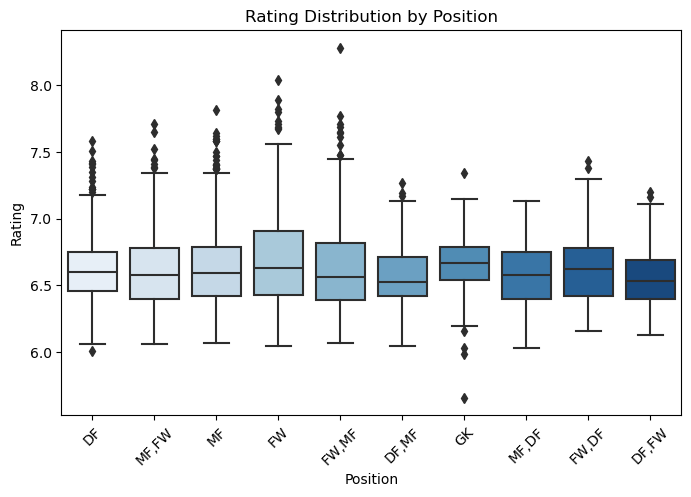

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.boxplot(data=clean_df, x="Pos", y="Rating", palette="Blues")

plt.title("Rating Distribution by Position")
plt.xlabel("Position")
plt.ylabel("Rating")
plt.xticks(rotation=45)

plt.show()


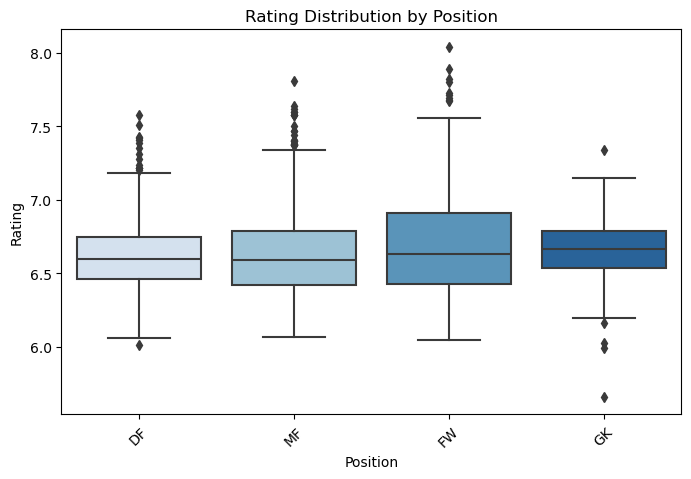

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

main_positions = clean_df[clean_df["Pos"].isin(["GK", "DF", "MF", "FW"])]

plt.figure(figsize=(8, 5))
sns.boxplot(data=main_positions, x="Pos", y="Rating", palette="Blues")

plt.title("Rating Distribution by Position")
plt.xlabel("Position")
plt.ylabel("Rating")
plt.xticks(rotation=45)

plt.show()

/var/folders/rj/gkzv_bs14qg22pdz7mcwyfww0000gn/T/ipykernel_21914/4051729060.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df["Grouped Positions"] = clean_df["Pos"].replace({


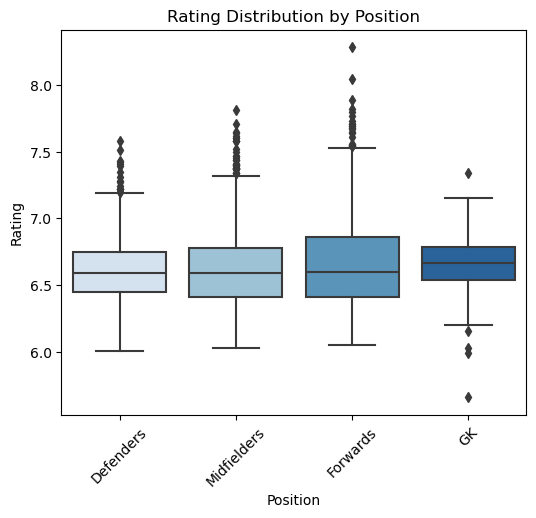

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

clean_df["Grouped Positions"] = clean_df["Pos"].replace({
    "DF": "Defenders",
    "DF,MF": "Defenders",
    "DF,FW" : "Defenders",
    "MF": "Midfielders",
    "MF,DF": "Midfielders",
    "MF,FW": "Midfielders",
    "FW": "Forwards",
    "FW,DF": "Forwards",
    "FW,MF": "Forwards"    
})


plt.figure(figsize=(6, 5))
sns.boxplot(data=clean_df, x="Grouped Positions", y="Rating", palette="Blues")

plt.title("Rating Distribution by Position")
plt.xlabel("Position")
plt.ylabel("Rating")
plt.xticks(rotation=45)

plt.show()

In [26]:
clean_df

,Player Name,Pos,Squad,League,90s,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,...,Crs,PKcon,OG,Recov,Won,Lost,Won%,Season,Rating,Grouped Positions
0,Max Aarons,DF,Bournemouth,Premier League,13.7,29,19,20,7,2,...,13,1,0,75,5,11,31.3,2023-2024,6.25,Defenders
1,Brenden Aaronson,"MF,FW",Union Berlin,Bundesliga,14.1,32,18,13,13,6,...,22,0,0,88,13,16,44.8,2023-2024,6.40,Midfielders
2,Yunis Abdelhamid,DF,Reims,Ligue 1,30.9,64,35,36,23,5,...,3,0,1,149,61,37,62.2,2023-2024,6.77,Defenders
3,Salis Abdul Samed,MF,Lens,Ligue 1,16.9,21,14,8,10,3,...,3,3,0,89,2,7,22.2,2023-2024,6.22,Midfielders
4,Laurent Abergel,MF,Lorient,Ligue 1,31.8,85,52,43,34,8,...,34,0,0,226,15,14,51.7,2023-2024,6.91,Midfielders
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,Igor Zubeldia,DF,Real Sociedad,La Liga,18.3,20,10,12,8,0,...,4,1,0,90,41,34,54.7,2021-2022,6.41,Defenders
2019,Martín Zubimendi,MF,Real Sociedad,La Liga,28.8,52,25,19,30,3,...,2,0,0,139,63,24,72.4,2021-2022,6.76,Midfielders
2020,Szymon Żurkowski,MF,Empoli,Serie A,25.6,58,33,24,21,13,...,23,1,0,162,24,32,42.9,2021-2022,6.80,Midfielders
2021,Martin Ødegaard,"MF,FW",Arsenal,Premier League,30.9,49,21,6,24,19,...,59,2,0,162,14,23,37.8,2021-2022,6.91,Midfielders


In [27]:
clean_df.sort_values(by="Rating", ascending=False)

,Player Name,Pos,Squad,League,90s,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,...,Crs,PKcon,OG,Recov,Won,Lost,Won%,Season,Rating,Grouped Positions
1266,Lionel Messi,"FW,MF",Paris S-G,Ligue 1,31.5,26,18,1,13,12,...,91,0,0,75,1,3,25.0,2022-2023,8.28,Forwards
1205,Kylian Mbappé,FW,Paris S-G,Ligue 1,33.6,11,8,1,4,6,...,68,0,0,63,4,10,28.6,2021-2022,8.04,Forwards
1051,Robert Lewandowski,FW,Bayern Munich,Bundesliga,32.7,10,3,0,6,4,...,26,0,0,72,53,58,47.7,2021-2022,7.89,Forwards
893,Harry Kane,FW,Bayern Munich,Bundesliga,31.5,13,9,4,4,5,...,31,0,0,55,30,34,46.9,2023-2024,7.82,Forwards
180,Jude Bellingham,MF,Real Madrid,La Liga,25.7,42,34,14,18,10,...,21,0,0,118,24,25,49.0,2023-2024,7.81,Midfielders
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
577,Aitor Fernández,GK,Osasuna,La Liga,6.1,0,0,0,0,0,...,0,0,0,11,0,1,0.0,2023-2024,6.03,GK
795,Martin Hongla,"MF,DF",Granada,La Liga,6.2,7,3,2,5,0,...,2,0,0,37,3,12,20.0,2023-2024,6.03,Midfielders
1554,Connor Roberts,DF,Burnley,Premier League,9.1,12,5,6,4,2,...,10,0,0,40,6,7,46.2,2023-2024,6.01,Defenders
1234,Alex McCarthy,GK,Southampton,Premier League,6.0,0,0,0,0,0,...,0,0,0,7,1,0,100.0,2022-2023,5.99,GK


In [28]:
clean_df.to_csv("3_seasons_old_ratings.csv", index=False)

In [29]:
clean_df_2021_2022 = clean_df[clean_df["Season"] == "2021-2022"]

In [30]:
clean_df_2021_2022.sort_values(by="Rating", ascending=False)

,Player Name,Pos,Squad,League,90s,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,...,Crs,PKcon,OG,Recov,Won,Lost,Won%,Season,Rating,Grouped Positions
1205,Kylian Mbappé,FW,Paris S-G,Ligue 1,33.6,11,8,1,4,6,...,68,0,0,63,4,10,28.6,2021-2022,8.04,Forwards
1051,Robert Lewandowski,FW,Bayern Munich,Bundesliga,32.7,10,3,0,6,4,...,26,0,0,72,53,58,47.7,2021-2022,7.89,Forwards
1243,Lionel Messi,"FW,MF",Paris S-G,Ligue 1,23.9,10,3,1,5,4,...,32,0,0,55,4,3,57.1,2021-2022,7.77,Forwards
190,Karim Benzema,FW,Real Madrid,La Liga,28.8,11,9,5,3,3,...,10,0,0,44,18,30,37.5,2021-2022,7.69,Forwards
1348,Neymar,"FW,MF",Paris S-G,Ligue 1,20.6,29,19,5,12,12,...,64,0,0,84,5,4,55.6,2021-2022,7.65,Forwards
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,Simon Asta,DF,Greuther Fürth,Bundesliga,8.7,13,6,4,5,4,...,16,0,1,50,4,5,44.4,2021-2022,6.10,Defenders
1720,Fábio Silva,FW,Wolves,Premier League,6.4,3,2,0,2,1,...,2,0,0,18,9,27,25.0,2021-2022,6.09,Forwards
1218,Nathan de Medina,DF,Arminia,Bundesliga,8.6,17,10,11,6,0,...,5,0,0,43,8,14,36.4,2021-2022,6.09,Defenders
277,Martín Cáceres,DF,Levante,La Liga,7.4,2,2,2,0,0,...,4,0,0,43,7,12,36.8,2021-2022,6.09,Defenders


In [31]:
clean_df_2021_2022.to_csv("2021_2022_player_ratings.csv", index=False)

In [32]:
clean_df_2022_2023 = clean_df[clean_df["Season"] == "2022-2023"]

In [33]:
clean_df_2022_2023.sort_values(by="Rating", ascending=False)

,Player Name,Pos,Squad,League,90s,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,...,Crs,PKcon,OG,Recov,Won,Lost,Won%,Season,Rating,Grouped Positions
1266,Lionel Messi,"FW,MF",Paris S-G,Ligue 1,31.5,26,18,1,13,12,...,91,0,0,75,1,3,25.0,2022-2023,8.28,Forwards
1230,Kylian Mbappé,FW,Paris S-G,Ligue 1,31.3,10,4,0,5,5,...,47,0,0,54,8,5,61.5,2022-2023,7.80,Forwards
1835,Martin Terrier,"FW,MF",Rennes,Ligue 1,14.7,25,11,7,9,9,...,13,0,0,58,63,37,63.0,2022-2023,7.71,Forwards
1367,Neymar,"MF,FW",Paris S-G,Ligue 1,17.2,22,14,6,9,7,...,54,0,0,63,1,2,33.3,2022-2023,7.71,Midfielders
750,Antoine Griezmann,"FW,MF",Atlético Madrid,La Liga,31.8,49,34,15,23,11,...,131,0,0,150,28,34,45.2,2022-2023,7.69,Forwards
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
790,Christian Gytkjær,"FW,MF",Monza,Serie A,6.2,6,2,1,4,1,...,1,1,0,9,10,20,33.3,2022-2023,6.07,Forwards
1249,Houboulang Mendes,DF,Almería,La Liga,9.8,19,11,16,3,0,...,31,1,0,37,1,1,50.0,2022-2023,6.06,Defenders
95,Santiago Arzamendia,"DF,MF",Cádiz,La Liga,5.4,9,8,7,1,1,...,14,0,0,46,6,6,50.0,2022-2023,6.05,Defenders
1234,Alex McCarthy,GK,Southampton,Premier League,6.0,0,0,0,0,0,...,0,0,0,7,1,0,100.0,2022-2023,5.99,GK


In [34]:
clean_df_2022_2023.to_csv("2022_2023_player_ratings.csv", index=False)

In [35]:
clean_df_2023_2024 = clean_df[clean_df["Season"] == "2023-2024"]

In [36]:
(clean_df_2023_2024.sort_values(by="Rating", ascending=False)).head(20)

,Player Name,Pos,Squad,League,90s,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,...,Crs,PKcon,OG,Recov,Won,Lost,Won%,Season,Rating,Grouped Positions
893,Harry Kane,FW,Bayern Munich,Bundesliga,31.5,13,9,4,4,5,...,31,0,0,55,30,34,46.9,2023-2024,7.82,Forwards
180,Jude Bellingham,MF,Real Madrid,La Liga,25.7,42,34,14,18,10,...,21,0,0,118,24,25,49.0,2023-2024,7.81,Midfielders
721,Serhou Guirassy,FW,Stuttgart,Bundesliga,24.5,6,3,1,4,1,...,1,0,0,39,65,55,54.2,2023-2024,7.73,Forwards
1176,Kylian Mbappé,FW,Paris S-G,Ligue 1,24.0,4,1,1,1,2,...,23,0,0,47,0,2,0.0,2023-2024,7.71,Forwards
1633,Leroy Sané,FW,Bayern Munich,Bundesliga,23.7,15,8,6,6,3,...,86,0,0,97,3,2,60.0,2023-2024,7.68,Forwards
1608,Bukayo Saka,FW,Arsenal,Premier League,32.4,66,35,22,24,20,...,181,0,0,155,23,36,39.0,2023-2024,7.67,Forwards
1290,Jamal Musiala,"MF,FW",Bayern Munich,Bundesliga,19.5,40,25,9,21,10,...,11,0,0,91,7,11,38.9,2023-2024,7.65,Midfielders
1559,Rodri,MF,Manchester City,Premier League,32.6,70,43,25,33,12,...,12,0,0,235,54,22,71.1,2023-2024,7.62,Midfielders
1364,Michael Olise,"FW,MF",Crystal Palace,Premier League,14.2,19,10,7,10,2,...,97,0,0,68,7,15,31.8,2023-2024,7.61,Forwards
430,Kevin De Bruyne,MF,Manchester City,Premier League,13.6,14,9,1,5,8,...,136,0,0,54,6,5,54.5,2023-2024,7.60,Midfielders


In [37]:
clean_df_2023_2024.to_csv("2023_2024_player_ratings.csv", index=False)

In [38]:
new_df = pd.read_csv("adjusted_ratings.csv")

In [39]:
new_df

,Player Name,Pos,Squad,League,90s,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,...,PKcon,OG,Recov,Won,Lost,Won%,Season,Rating,Adjusted Rating,Adjustment
0,Max Aarons,DF,Bournemouth,Premier League,13.7,29,19,20,7,2,...,1,0,75,5,11,31.3,2023-2024,6.25,6.140568,-0.109432
1,Yunis Abdelhamid,DF,Reims,Ligue 1,30.9,64,35,36,23,5,...,0,1,149,61,37,62.2,2023-2024,6.77,6.816568,0.046568
2,Salis Abdul Samed,MF,Lens,Ligue 1,16.9,21,14,8,10,3,...,3,0,89,2,7,22.2,2023-2024,6.22,6.220000,0.000000
3,Laurent Abergel,MF,Lorient,Ligue 1,31.8,85,52,43,34,8,...,0,0,226,15,14,51.7,2023-2024,6.91,6.910000,0.000000
4,Abner,DF,Betis,La Liga,15.6,25,19,15,9,1,...,1,0,79,14,10,58.3,2023-2024,6.41,6.348568,-0.061432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3516,Nadir Zortea,"DF,MF",Salernitana,Serie A,15.7,21,15,9,7,5,...,0,0,72,8,17,32.0,2021-2022,6.36,6.360000,0.000000
3517,Kurt Zouma,DF,West Ham,Premier League,23.1,11,6,8,3,0,...,0,1,92,50,31,61.7,2021-2022,6.74,6.777568,0.037568
3518,Igor Zubeldia,DF,Real Sociedad,La Liga,18.3,20,10,12,8,0,...,1,0,90,41,34,54.7,2021-2022,6.41,6.348568,-0.061432
3519,Martín Zubimendi,MF,Real Sociedad,La Liga,28.8,52,25,19,30,3,...,0,0,139,63,24,72.4,2021-2022,6.76,6.760000,0.000000


In [40]:
players_3_seasons = clean_df[['Player Name', 'Season', 'Rating']]

In [41]:
players_3_seasons.duplicated().sum()

1

In [42]:
players_new_df = new_df[['Player Name', 'Season', 'Rating']]

In [43]:
players_new_df

,Player Name,Season,Rating
0,Max Aarons,2023-2024,6.25
1,Yunis Abdelhamid,2023-2024,6.77
2,Salis Abdul Samed,2023-2024,6.22
3,Laurent Abergel,2023-2024,6.91
4,Abner,2023-2024,6.41
...,...,...,...
3516,Nadir Zortea,2021-2022,6.36
3517,Kurt Zouma,2021-2022,6.74
3518,Igor Zubeldia,2021-2022,6.41
3519,Martín Zubimendi,2021-2022,6.76


In [44]:
newdf=pd.concat([players_3_seasons,players_new_df]).drop_duplicates(keep=False)


In [45]:
newdf

,Player Name,Season,Rating
1,Brenden Aaronson,2023-2024,6.40
5,Matthis Abline,2023-2024,6.55
7,Zakaria Aboukhlal,2023-2024,6.42
11,Akor Adams,2023-2024,6.59
12,Sargis Adamyan,2023-2024,6.33
...,...,...,...
2013,Hakim Ziyech,2021-2022,6.92
2014,Jeroen Zoet,2021-2022,6.21
2015,Simon Zoller,2021-2022,6.60
2021,Martin Ødegaard,2021-2022,6.91


In [46]:
missing_players = clean_df[~clean_df[['Player Name', 'Season', 'Rating']].apply(tuple, axis=1).isin(new_df[['Player Name', 'Season', 'Rating']].apply(tuple, axis=1))]


In [47]:
missing_players

,Player Name,Pos,Squad,League,90s,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,...,Crs,PKcon,OG,Recov,Won,Lost,Won%,Season,Rating,Grouped Positions
1,Brenden Aaronson,"MF,FW",Union Berlin,Bundesliga,14.1,32,18,13,13,6,...,22,0,0,88,13,16,44.8,2023-2024,6.40,Midfielders
5,Matthis Abline,FW,Nantes,Ligue 1,11.6,9,4,4,3,2,...,7,0,0,39,15,27,35.7,2023-2024,6.55,Forwards
7,Zakaria Aboukhlal,"MF,FW",Toulouse,Ligue 1,8.4,9,8,1,5,3,...,5,0,0,21,6,7,46.2,2023-2024,6.42,Midfielders
11,Akor Adams,FW,Montpellier,Ligue 1,25.0,12,4,3,4,5,...,12,0,0,55,54,69,43.9,2023-2024,6.59,Forwards
12,Sargis Adamyan,"FW,MF",Köln,Bundesliga,8.9,14,9,2,9,3,...,4,0,0,30,14,37,27.5,2023-2024,6.33,Forwards
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,Hakim Ziyech,"MF,FW",Chelsea,Premier League,14.7,19,10,5,12,2,...,101,0,0,87,12,14,46.2,2021-2022,6.92,Midfielders
2014,Jeroen Zoet,GK,Spezia,Serie A,7.0,1,0,1,0,0,...,0,1,0,5,2,1,66.7,2021-2022,6.21,GK
2015,Simon Zoller,FW,Bochum,Bundesliga,6.6,4,2,2,1,1,...,10,0,0,22,6,4,60.0,2021-2022,6.60,Forwards
2021,Martin Ødegaard,"MF,FW",Arsenal,Premier League,30.9,49,21,6,24,19,...,59,2,0,162,14,23,37.8,2021-2022,6.91,Midfielders


In [48]:
new_df

,Player Name,Pos,Squad,League,90s,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,...,PKcon,OG,Recov,Won,Lost,Won%,Season,Rating,Adjusted Rating,Adjustment
0,Max Aarons,DF,Bournemouth,Premier League,13.7,29,19,20,7,2,...,1,0,75,5,11,31.3,2023-2024,6.25,6.140568,-0.109432
1,Yunis Abdelhamid,DF,Reims,Ligue 1,30.9,64,35,36,23,5,...,0,1,149,61,37,62.2,2023-2024,6.77,6.816568,0.046568
2,Salis Abdul Samed,MF,Lens,Ligue 1,16.9,21,14,8,10,3,...,3,0,89,2,7,22.2,2023-2024,6.22,6.220000,0.000000
3,Laurent Abergel,MF,Lorient,Ligue 1,31.8,85,52,43,34,8,...,0,0,226,15,14,51.7,2023-2024,6.91,6.910000,0.000000
4,Abner,DF,Betis,La Liga,15.6,25,19,15,9,1,...,1,0,79,14,10,58.3,2023-2024,6.41,6.348568,-0.061432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3516,Nadir Zortea,"DF,MF",Salernitana,Serie A,15.7,21,15,9,7,5,...,0,0,72,8,17,32.0,2021-2022,6.36,6.360000,0.000000
3517,Kurt Zouma,DF,West Ham,Premier League,23.1,11,6,8,3,0,...,0,1,92,50,31,61.7,2021-2022,6.74,6.777568,0.037568
3518,Igor Zubeldia,DF,Real Sociedad,La Liga,18.3,20,10,12,8,0,...,1,0,90,41,34,54.7,2021-2022,6.41,6.348568,-0.061432
3519,Martín Zubimendi,MF,Real Sociedad,La Liga,28.8,52,25,19,30,3,...,0,0,139,63,24,72.4,2021-2022,6.76,6.760000,0.000000


In [49]:
missing_players['Adjusted Rating'] = missing_players['Rating']

/var/folders/rj/gkzv_bs14qg22pdz7mcwyfww0000gn/T/ipykernel_21914/2627663092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_players['Adjusted Rating'] = missing_players['Rating']


In [50]:
missing_players['Adjustment'] = missing_players['Rating'] - missing_players['Adjusted Rating']

/var/folders/rj/gkzv_bs14qg22pdz7mcwyfww0000gn/T/ipykernel_21914/1479016869.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_players['Adjustment'] = missing_players['Rating'] - missing_players['Adjusted Rating']


In [51]:
missing_players

,Player Name,Pos,Squad,League,90s,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,...,OG,Recov,Won,Lost,Won%,Season,Rating,Grouped Positions,Adjusted Rating,Adjustment
1,Brenden Aaronson,"MF,FW",Union Berlin,Bundesliga,14.1,32,18,13,13,6,...,0,88,13,16,44.8,2023-2024,6.40,Midfielders,6.40,0.0
5,Matthis Abline,FW,Nantes,Ligue 1,11.6,9,4,4,3,2,...,0,39,15,27,35.7,2023-2024,6.55,Forwards,6.55,0.0
7,Zakaria Aboukhlal,"MF,FW",Toulouse,Ligue 1,8.4,9,8,1,5,3,...,0,21,6,7,46.2,2023-2024,6.42,Midfielders,6.42,0.0
11,Akor Adams,FW,Montpellier,Ligue 1,25.0,12,4,3,4,5,...,0,55,54,69,43.9,2023-2024,6.59,Forwards,6.59,0.0
12,Sargis Adamyan,"FW,MF",Köln,Bundesliga,8.9,14,9,2,9,3,...,0,30,14,37,27.5,2023-2024,6.33,Forwards,6.33,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,Hakim Ziyech,"MF,FW",Chelsea,Premier League,14.7,19,10,5,12,2,...,0,87,12,14,46.2,2021-2022,6.92,Midfielders,6.92,0.0
2014,Jeroen Zoet,GK,Spezia,Serie A,7.0,1,0,1,0,0,...,0,5,2,1,66.7,2021-2022,6.21,GK,6.21,0.0
2015,Simon Zoller,FW,Bochum,Bundesliga,6.6,4,2,2,1,1,...,0,22,6,4,60.0,2021-2022,6.60,Forwards,6.60,0.0
2021,Martin Ødegaard,"MF,FW",Arsenal,Premier League,30.9,49,21,6,24,19,...,0,162,14,23,37.8,2021-2022,6.91,Midfielders,6.91,0.0


In [52]:
new_df["Grouped Positions"] = new_df["Pos"].replace({
    "DF": "Defenders",
    "DF,MF": "Defenders",
    "DF,FW" : "Defenders",
    "MF": "Midfielders",
    "MF,DF": "Midfielders",
    "MF,FW": "Midfielders",
    "FW": "Forwards",
    "FW,DF": "Forwards",
    "FW,MF": "Forwards"    
})

In [53]:
new_df

,Player Name,Pos,Squad,League,90s,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,...,OG,Recov,Won,Lost,Won%,Season,Rating,Adjusted Rating,Adjustment,Grouped Positions
0,Max Aarons,DF,Bournemouth,Premier League,13.7,29,19,20,7,2,...,0,75,5,11,31.3,2023-2024,6.25,6.140568,-0.109432,Defenders
1,Yunis Abdelhamid,DF,Reims,Ligue 1,30.9,64,35,36,23,5,...,1,149,61,37,62.2,2023-2024,6.77,6.816568,0.046568,Defenders
2,Salis Abdul Samed,MF,Lens,Ligue 1,16.9,21,14,8,10,3,...,0,89,2,7,22.2,2023-2024,6.22,6.220000,0.000000,Midfielders
3,Laurent Abergel,MF,Lorient,Ligue 1,31.8,85,52,43,34,8,...,0,226,15,14,51.7,2023-2024,6.91,6.910000,0.000000,Midfielders
4,Abner,DF,Betis,La Liga,15.6,25,19,15,9,1,...,0,79,14,10,58.3,2023-2024,6.41,6.348568,-0.061432,Defenders
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3516,Nadir Zortea,"DF,MF",Salernitana,Serie A,15.7,21,15,9,7,5,...,0,72,8,17,32.0,2021-2022,6.36,6.360000,0.000000,Defenders
3517,Kurt Zouma,DF,West Ham,Premier League,23.1,11,6,8,3,0,...,1,92,50,31,61.7,2021-2022,6.74,6.777568,0.037568,Defenders
3518,Igor Zubeldia,DF,Real Sociedad,La Liga,18.3,20,10,12,8,0,...,0,90,41,34,54.7,2021-2022,6.41,6.348568,-0.061432,Defenders
3519,Martín Zubimendi,MF,Real Sociedad,La Liga,28.8,52,25,19,30,3,...,0,139,63,24,72.4,2021-2022,6.76,6.760000,0.000000,Midfielders


In [54]:
missing_players

,Player Name,Pos,Squad,League,90s,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,...,OG,Recov,Won,Lost,Won%,Season,Rating,Grouped Positions,Adjusted Rating,Adjustment
1,Brenden Aaronson,"MF,FW",Union Berlin,Bundesliga,14.1,32,18,13,13,6,...,0,88,13,16,44.8,2023-2024,6.40,Midfielders,6.40,0.0
5,Matthis Abline,FW,Nantes,Ligue 1,11.6,9,4,4,3,2,...,0,39,15,27,35.7,2023-2024,6.55,Forwards,6.55,0.0
7,Zakaria Aboukhlal,"MF,FW",Toulouse,Ligue 1,8.4,9,8,1,5,3,...,0,21,6,7,46.2,2023-2024,6.42,Midfielders,6.42,0.0
11,Akor Adams,FW,Montpellier,Ligue 1,25.0,12,4,3,4,5,...,0,55,54,69,43.9,2023-2024,6.59,Forwards,6.59,0.0
12,Sargis Adamyan,"FW,MF",Köln,Bundesliga,8.9,14,9,2,9,3,...,0,30,14,37,27.5,2023-2024,6.33,Forwards,6.33,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,Hakim Ziyech,"MF,FW",Chelsea,Premier League,14.7,19,10,5,12,2,...,0,87,12,14,46.2,2021-2022,6.92,Midfielders,6.92,0.0
2014,Jeroen Zoet,GK,Spezia,Serie A,7.0,1,0,1,0,0,...,0,5,2,1,66.7,2021-2022,6.21,GK,6.21,0.0
2015,Simon Zoller,FW,Bochum,Bundesliga,6.6,4,2,2,1,1,...,0,22,6,4,60.0,2021-2022,6.60,Forwards,6.60,0.0
2021,Martin Ødegaard,"MF,FW",Arsenal,Premier League,30.9,49,21,6,24,19,...,0,162,14,23,37.8,2021-2022,6.91,Midfielders,6.91,0.0


In [55]:
columns = [col for col in missing_players if col != 'Grouped Positions']  # Get all columns except 'Score'
columns.append('Grouped Positions')

missing_players = missing_players[columns]

In [56]:
missing_players

,Player Name,Pos,Squad,League,90s,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,...,OG,Recov,Won,Lost,Won%,Season,Rating,Adjusted Rating,Adjustment,Grouped Positions
1,Brenden Aaronson,"MF,FW",Union Berlin,Bundesliga,14.1,32,18,13,13,6,...,0,88,13,16,44.8,2023-2024,6.40,6.40,0.0,Midfielders
5,Matthis Abline,FW,Nantes,Ligue 1,11.6,9,4,4,3,2,...,0,39,15,27,35.7,2023-2024,6.55,6.55,0.0,Forwards
7,Zakaria Aboukhlal,"MF,FW",Toulouse,Ligue 1,8.4,9,8,1,5,3,...,0,21,6,7,46.2,2023-2024,6.42,6.42,0.0,Midfielders
11,Akor Adams,FW,Montpellier,Ligue 1,25.0,12,4,3,4,5,...,0,55,54,69,43.9,2023-2024,6.59,6.59,0.0,Forwards
12,Sargis Adamyan,"FW,MF",Köln,Bundesliga,8.9,14,9,2,9,3,...,0,30,14,37,27.5,2023-2024,6.33,6.33,0.0,Forwards
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013,Hakim Ziyech,"MF,FW",Chelsea,Premier League,14.7,19,10,5,12,2,...,0,87,12,14,46.2,2021-2022,6.92,6.92,0.0,Midfielders
2014,Jeroen Zoet,GK,Spezia,Serie A,7.0,1,0,1,0,0,...,0,5,2,1,66.7,2021-2022,6.21,6.21,0.0,GK
2015,Simon Zoller,FW,Bochum,Bundesliga,6.6,4,2,2,1,1,...,0,22,6,4,60.0,2021-2022,6.60,6.60,0.0,Forwards
2021,Martin Ødegaard,"MF,FW",Arsenal,Premier League,30.9,49,21,6,24,19,...,0,162,14,23,37.8,2021-2022,6.91,6.91,0.0,Midfielders


In [57]:
new_df

,Player Name,Pos,Squad,League,90s,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,...,OG,Recov,Won,Lost,Won%,Season,Rating,Adjusted Rating,Adjustment,Grouped Positions
0,Max Aarons,DF,Bournemouth,Premier League,13.7,29,19,20,7,2,...,0,75,5,11,31.3,2023-2024,6.25,6.140568,-0.109432,Defenders
1,Yunis Abdelhamid,DF,Reims,Ligue 1,30.9,64,35,36,23,5,...,1,149,61,37,62.2,2023-2024,6.77,6.816568,0.046568,Defenders
2,Salis Abdul Samed,MF,Lens,Ligue 1,16.9,21,14,8,10,3,...,0,89,2,7,22.2,2023-2024,6.22,6.220000,0.000000,Midfielders
3,Laurent Abergel,MF,Lorient,Ligue 1,31.8,85,52,43,34,8,...,0,226,15,14,51.7,2023-2024,6.91,6.910000,0.000000,Midfielders
4,Abner,DF,Betis,La Liga,15.6,25,19,15,9,1,...,0,79,14,10,58.3,2023-2024,6.41,6.348568,-0.061432,Defenders
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3516,Nadir Zortea,"DF,MF",Salernitana,Serie A,15.7,21,15,9,7,5,...,0,72,8,17,32.0,2021-2022,6.36,6.360000,0.000000,Defenders
3517,Kurt Zouma,DF,West Ham,Premier League,23.1,11,6,8,3,0,...,1,92,50,31,61.7,2021-2022,6.74,6.777568,0.037568,Defenders
3518,Igor Zubeldia,DF,Real Sociedad,La Liga,18.3,20,10,12,8,0,...,0,90,41,34,54.7,2021-2022,6.41,6.348568,-0.061432,Defenders
3519,Martín Zubimendi,MF,Real Sociedad,La Liga,28.8,52,25,19,30,3,...,0,139,63,24,72.4,2021-2022,6.76,6.760000,0.000000,Midfielders


In [58]:
final_df = pd.concat([missing_players, new_df], axis=0, ignore_index=True)

In [59]:
final_df

,Player Name,Pos,Squad,League,90s,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,...,OG,Recov,Won,Lost,Won%,Season,Rating,Adjusted Rating,Adjustment,Grouped Positions
0,Brenden Aaronson,"MF,FW",Union Berlin,Bundesliga,14.1,32,18,13,13,6,...,0,88,13,16,44.8,2023-2024,6.40,6.400000,0.000000,Midfielders
1,Matthis Abline,FW,Nantes,Ligue 1,11.6,9,4,4,3,2,...,0,39,15,27,35.7,2023-2024,6.55,6.550000,0.000000,Forwards
2,Zakaria Aboukhlal,"MF,FW",Toulouse,Ligue 1,8.4,9,8,1,5,3,...,0,21,6,7,46.2,2023-2024,6.42,6.420000,0.000000,Midfielders
3,Akor Adams,FW,Montpellier,Ligue 1,25.0,12,4,3,4,5,...,0,55,54,69,43.9,2023-2024,6.59,6.590000,0.000000,Forwards
4,Sargis Adamyan,"FW,MF",Köln,Bundesliga,8.9,14,9,2,9,3,...,0,30,14,37,27.5,2023-2024,6.33,6.330000,0.000000,Forwards
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5645,Nadir Zortea,"DF,MF",Salernitana,Serie A,15.7,21,15,9,7,5,...,0,72,8,17,32.0,2021-2022,6.36,6.360000,0.000000,Defenders
5646,Kurt Zouma,DF,West Ham,Premier League,23.1,11,6,8,3,0,...,1,92,50,31,61.7,2021-2022,6.74,6.777568,0.037568,Defenders
5647,Igor Zubeldia,DF,Real Sociedad,La Liga,18.3,20,10,12,8,0,...,0,90,41,34,54.7,2021-2022,6.41,6.348568,-0.061432,Defenders
5648,Martín Zubimendi,MF,Real Sociedad,La Liga,28.8,52,25,19,30,3,...,0,139,63,24,72.4,2021-2022,6.76,6.760000,0.000000,Midfielders


In [60]:
final_df.to_csv("tableau_adjusted.csv")

In [61]:
final_df[final_df['Season'] == '2021-2022'].sort_values(by="Adjusted Rating", ascending=False).head(20)

,Player Name,Pos,Squad,League,90s,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,...,OG,Recov,Won,Lost,Won%,Season,Rating,Adjusted Rating,Adjustment,Grouped Positions
1824,Kylian Mbappé,FW,Paris S-G,Ligue 1,33.6,11,8,1,4,6,...,0,63,4,10,28.6,2021-2022,8.04,8.040000,0.000000,Forwards
1774,Robert Lewandowski,FW,Bayern Munich,Bundesliga,32.7,10,3,0,6,4,...,0,72,53,58,47.7,2021-2022,7.89,7.890000,0.000000,Forwards
4500,Trent Alexander-Arnold,DF,Liverpool,Premier League,31.7,40,23,19,13,8,...,0,235,15,13,53.6,2021-2022,7.51,7.778568,0.268568,Defenders
1835,Lionel Messi,"FW,MF",Paris S-G,Ligue 1,23.9,10,3,1,5,4,...,0,55,4,3,57.1,2021-2022,7.77,7.770000,0.000000,Forwards
1474,Karim Benzema,FW,Real Madrid,La Liga,28.8,11,9,5,3,3,...,0,44,18,30,37.5,2021-2022,7.69,7.690000,0.000000,Forwards
4638,João Cancelo,DF,Manchester City,Premier League,35.9,83,54,33,35,15,...,0,217,57,51,52.8,2021-2022,7.43,7.674568,0.244568,Defenders
4670,Ben Chilwell,DF,Chelsea,Premier League,6.0,8,3,2,6,0,...,0,32,7,10,41.2,2021-2022,7.42,7.661568,0.241568,Defenders
1867,Neymar,"FW,MF",Paris S-G,Ligue 1,20.6,29,19,5,12,12,...,0,84,5,4,55.6,2021-2022,7.65,7.650000,0.000000,Forwards
1874,Christopher Nkunku,"FW,MF",RB Leipzig,Bundesliga,30.3,23,10,10,11,2,...,0,103,26,28,48.1,2021-2022,7.64,7.640000,0.000000,Forwards
4728,Kevin De Bruyne,MF,Manchester City,Premier League,24.5,32,16,4,15,13,...,0,114,11,18,37.9,2021-2022,7.64,7.640000,0.000000,Midfielders


In [62]:
(final_df[final_df['Season'] == '2023-2024']).sort_values(by='Adjusted Rating', ascending=False).head(20)

,Player Name,Pos,Squad,League,90s,Tkl,TklW,Def 3rd,Mid 3rd,Att 3rd,...,OG,Recov,Won,Lost,Won%,Season,Rating,Adjusted Rating,Adjustment,Grouped Positions
2522,Álex Grimaldo,DF,Leverkusen,Bundesliga,30.9,45,24,26,10,9,...,0,168,12,19,38.7,2023-2024,7.58,7.869568,0.289568,Defenders
326,Harry Kane,FW,Bayern Munich,Bundesliga,31.5,13,9,4,4,5,...,0,55,30,34,46.9,2023-2024,7.82,7.820000,0.000000,Forwards
2223,Jude Bellingham,MF,Real Madrid,La Liga,25.7,42,34,14,18,10,...,0,118,24,25,49.0,2023-2024,7.81,7.810000,0.000000,Midfielders
261,Serhou Guirassy,FW,Stuttgart,Bundesliga,24.5,6,3,1,4,1,...,0,39,65,55,54.2,2023-2024,7.73,7.730000,0.000000,Forwards
397,Kylian Mbappé,FW,Paris S-G,Ligue 1,24.0,4,1,1,1,2,...,0,47,0,2,0.0,2023-2024,7.71,7.710000,0.000000,Forwards
560,Leroy Sané,FW,Bayern Munich,Bundesliga,23.7,15,8,6,6,3,...,0,97,3,2,60.0,2023-2024,7.68,7.680000,0.000000,Forwards
551,Bukayo Saka,FW,Arsenal,Premier League,32.4,66,35,22,24,20,...,0,155,23,36,39.0,2023-2024,7.67,7.670000,0.000000,Forwards
438,Jamal Musiala,"MF,FW",Bayern Munich,Bundesliga,19.5,40,25,9,21,10,...,0,91,7,11,38.9,2023-2024,7.65,7.650000,0.000000,Midfielders
3015,Rodri,MF,Manchester City,Premier League,32.6,70,43,25,33,12,...,0,235,54,22,71.1,2023-2024,7.62,7.620000,0.000000,Midfielders
468,Michael Olise,"FW,MF",Crystal Palace,Premier League,14.2,19,10,7,10,2,...,0,68,7,15,31.8,2023-2024,7.61,7.610000,0.000000,Forwards
